# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import torch
from torch import optim, nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import torchvision
from PIL import Image
import time
import os
import sys
import copy
import getopt

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
data_dirs = {
    "train" : data_dir + '/train', 
    "valid" : data_dir + '/valid', 
    "test"  : data_dir + '/test'
}

In [4]:
batch_sz = 16

data_transforms = {
    "train" : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    "valid" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    "test" : transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}
    
# Load the datasets with ImageFolder
all_data = {x: datasets.ImageFolder(data_dirs[x], data_transforms[x]) 
            for x in ['train', 'valid', 'test']}

# useful for computing accuracy later
dataset_sizes = {x: len(all_data[x]) for x in ['train', 'valid', 'test']}

# get all of the different labels
class_names = all_data['train'].classes

# define the dataloaders
data_loaders = {x: torch.utils.data.DataLoader(all_data[x], batch_size=batch_sz, shuffle=True)
                for x in ['train', 'valid', 'test']}

In [5]:
def show_batch(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

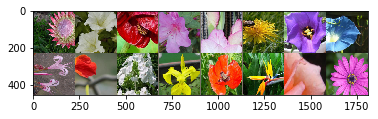

['bird of paradise', 'common dandelion', 'blanket flower', 'water lily', 'barbeton daisy', 'oxeye daisy', 'sword lily', 'passion flower', 'mexican aster', 'hippeastrum', 'artichoke', 'globe thistle', 'pincushion flower', 'frangipani', 'thorn apple', 'osteospermum']


In [7]:
# load a batch of training data
inputs, labels = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
show_batch(out)
print([cat_to_name[str(int(x)+1)] for x in labels])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [8]:
vgg16 = models.vgg16_bn(pretrained=True)
print(vgg16.classifier[6].out_features) 
# original model should have 1000 features in last layer

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:17<00:00, 31430554.95it/s]


1000


In [9]:
# default classifier for vgg16_bn
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [10]:
# change the last layer to output the class dimensionality of our dataset
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=len(class_names))

# show new classifier
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=102, bias=True)
)

In [11]:
# initialize weights and biases
vgg16.classifier[-1].bias.data.fill_(0)
vgg16.classifier[-1].weight.data.normal_(std=0.01);

In [12]:
# freeze vgg's parameters so that we can initialize the last layer's weights
for param in vgg16.parameters():
    param.requires_grad = False

In [13]:
# enable learning for the last layer of the model
for param in vgg16.classifier[-1].parameters():
    param.requires_grad_()

#### Resources:
* [Carlo Alberto's post on kaggle about using vgg16](https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch)
* [Pytorch's Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [14]:
# send model to gpu
vgg16.cuda()
    
# Our output is 102 class predictions so we are using NLL
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg16.classifier[-1].parameters(), lr=0.005, momentum=0.9)

# the scheduler can vary the learning rate 
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
epochs = 20
best_acc_epoch = 0
best_acc = 0.0
avg_loss_val = 0
avg_acc_val = 0
train_losses = []
train_accuracy = []
valid_losses = []
valid_accuracy = []
best_model_wts = copy.deepcopy(vgg16.state_dict())

since = time.time()
for e in range(epochs):
    for phase in ['train', 'valid']:
        running_loss = 0
        correct = 0
        num_instances = 0
        for inputs,labels in data_loaders[phase]:
            if phase == "train":
                vgg16.train(True)
            else:
                vgg16.train(False)
                vgg16.eval()
            # send data to the gpu
            inputs, labels = inputs.cuda(), labels.cuda()
            # reset the parameter's gradients
            optimizer_ft.zero_grad()
            # feed inputs forward
            output = vgg16(inputs)
            # get the VGG16 transfer model's predictions
            _, preds = torch.max(output.data, 1)
            # compute cross entropy error
            loss = criterion(output, labels)
            if phase == "train": 
                # backpropagate
                loss.backward()
                # gradient descend
                optimizer_ft.step()
            # for computing loss
            running_loss += loss.item()
            # for computing accuracy
            correct += torch.sum(preds == labels.data)
            # free gpu resources
            del inputs, labels, output, preds
            torch.cuda.empty_cache()
            
        epoch_acc = float(correct) / float(dataset_sizes[phase])
        
        if phase == "train":
            train_losses.append(running_loss)
            train_accuracy.append(epoch_acc)
        else: # "valid" 
            valid_losses.append(running_loss)
            valid_accuracy.append(epoch_acc)
            
        print("Epoch {}: {}\n\tTotal Loss: {:4f}\n\tAccuracy: {:d}/{:d} = {:4f}\n".format(
                    e, phase.upper(), running_loss, correct, dataset_sizes[phase], epoch_acc))                                                         
        
        if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_acc_epoch = e
            best_model_wts = copy.deepcopy(vgg16.state_dict())
            
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 0: TRAIN
	Total Loss: 818.203575
	Accuracy: 3569/6552 = 0.544719

Epoch 0: VALID
	Total Loss: 32.004876
	Accuracy: 691/818 = 0.844743

Epoch 1: TRAIN
	Total Loss: 414.785929
	Accuracy: 4818/6552 = 0.735348

Epoch 1: VALID
	Total Loss: 23.512576
	Accuracy: 718/818 = 0.877751

Epoch 2: TRAIN
	Total Loss: 355.658721
	Accuracy: 5040/6552 = 0.769231

Epoch 2: VALID
	Total Loss: 20.902074
	Accuracy: 716/818 = 0.875306

Epoch 3: TRAIN
	Total Loss: 325.407827
	Accuracy: 5136/6552 = 0.783883

Epoch 3: VALID
	Total Loss: 16.592152
	Accuracy: 742/818 = 0.907090

Epoch 4: TRAIN
	Total Loss: 310.488898
	Accuracy: 5207/6552 = 0.794719

Epoch 4: VALID
	Total Loss: 16.215634
	Accuracy: 745/818 = 0.910758

Epoch 5: TRAIN
	Total Loss: 291.817895
	Accuracy: 5258/6552 = 0.802503

Epoch 5: VALID
	Total Loss: 17.079383
	Accuracy: 748/818 = 0.914425

Epoch 6: TRAIN
	Total Loss: 279.368952
	Accuracy: 5293/6552 = 0.807845

Epoch 6: VALID
	Total Loss: 14.795969
	Accuracy: 756/818 = 0.924205

Epoch 7: TRAI

In [15]:
print("Best Accuracy: {} in epoch {}".format(
    round(best_acc, 3), best_acc_epoch))

Best Accuracy: 0.932 in epoch 17


#### Resources:
* [Useful Stack Overflow explanations of bbox_to_anchor (for legends)](https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132)
* [Matplotlib tutorial on twin axis in matplotlib](https://matplotlib.org/examples/api/two_scales.html)

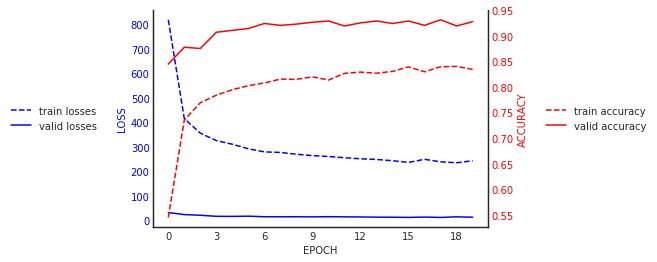

In [16]:
sns.set_style('white')
fig, ax1 = plt.subplots()
t = np.arange(e+1)
ax1.plot(t, train_losses, 'b--', label='train losses')
ax1.plot(t, valid_losses, 'b', label='valid losses')
ax1.set_xlabel('EPOCH')
ax1.set_ylabel('LOSS', color='b', )
ax1.tick_params('y', colors='b')
ax1.spines['top'].set_visible(False)
ax1.legend(bbox_to_anchor=(-0.14, 0.6), fancybox=True, shadow=True) # center
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(t, train_accuracy, 'r--', label='train accuracy')
ax2.plot(t, valid_accuracy, 'r', label='valid accuracy')
ax2.set_ylabel('ACCURACY', color='r')
ax2.tick_params('y', colors='r')
ax2.spines['top'].set_visible(False)
ax2.legend(bbox_to_anchor=(1.5, 0.6), fancybox=True) # center right
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
phase = 'test'
correct = 0
for inputs,labels in data_loaders[phase]:
    # leave parameters as are during testing
    vgg16.train(False)
    vgg16.eval()
    # send data to the gpu
    inputs, labels = inputs.cuda(), labels.cuda()
    # reset the parameter's gradients
    optimizer_ft.zero_grad()
    # feed inputs forward
    output = vgg16(inputs)
    # get the VGG16 transfer model's predictions
    _, preds = torch.max(output.data, 1)
    # compute cross entropy error
    loss = criterion(output, labels)
    # for computing loss
    running_loss += loss.item()
    # for computing accuracy
    correct += torch.sum(preds == labels.data)
    # free gpu resources
    del inputs, labels, output, preds
    torch.cuda.empty_cache()

test_acc = float(correct) / float(dataset_sizes[phase])

print("{}\nTotal Loss: {:4f}\nAccuracy: {:d}/{:d} = {:4f}".format(
            phase.upper(), running_loss, correct, dataset_sizes[phase], test_acc))                                                         

TEST
Total Loss: 43.136747
Accuracy: 693/819 = 0.846154


BATCH ACCURACY: 0.9375

BATCH PREDICTION ERROR 1
Actual: mallow with probability 0.011
MODEL TOP 5 PREDICTIONS
Prediction: foxglove with probability 0.783
Prediction: canna lily with probability 0.060
Prediction: purple coneflower with probability 0.034
Prediction: love in the mist with probability 0.021
Prediction: carnation with probability 0.016



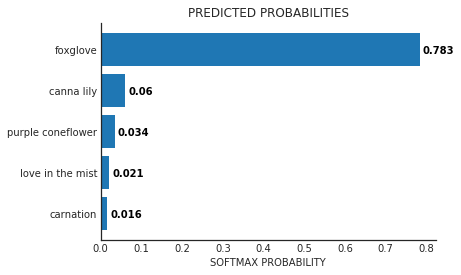

In [36]:
phase = 'test'
correct = 0

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x))

for inputs,labels in data_loaders[phase]:
    # leave parameters as are during testing
    vgg16.train(False)
    vgg16.eval()
    # send data to the gpu
    inputs, labels = inputs.cuda(), labels.cuda()
    # reset the parameter's gradients
    optimizer_ft.zero_grad()
    # feed inputs forward
    output = vgg16(inputs)
    # get the VGG16 transfer model's predictions
    _, preds = torch.max(output.data, 1)
    correct += torch.sum(preds == labels.data)
    acc = float(correct)/float(len(labels))
    print("BATCH ACCURACY: {}\n".format(acc))
    
    error_count = 0
    for i, label in enumerate(labels):
        pred  = torch.argmax(output[i])
        if pred != label:
            error_count += 1
            print("BATCH PREDICTION ERROR {}".format(error_count))
            sorted_outputs, indices = torch.sort(output[i])
            
            # what were the model's top outputs? 
            top_5_outputs_names = []
            for j in list(indices[-5:]):
                top_5_outputs_names.append(cat_to_name[str(int(j) + 1)])
            top_5_outputs_names.reverse()
            
            # find corresponding probabilties for top outputs
            sorted_probs = softmax(sorted_outputs).cpu().detach()
            top_5_probs = list(sorted_probs[-5:])
            top_5_probs.reverse()
            
            actual_flower = cat_to_name[str(int(label) + 1)]
            prob_assigned_to_actual = softmax(output[i])[label]
            print("Actual: {} with probability {:.3f}".format(
                actual_flower, prob_assigned_to_actual))
            
            print("MODEL TOP 5 PREDICTIONS")
            for flower_name, prob in zip(top_5_outputs_names, 
                                         top_5_probs):
                print("Prediction: {} with probability {:.3f}".format(
                    flower_name, prob))
            print()
            
            fig, ax = plt.subplots()
            ax.barh(np.arange(5), np.array(top_5_probs), 
                    align='center')
            ax.set_yticks(np.arange(5))
            ax.set_yticklabels(top_5_outputs_names)
            ax.invert_yaxis()
            
            for i, prob in enumerate(np.array(top_5_probs)):
                ax.text(prob + (np.max(top_5_probs) / 100), i+.1, round(prob,3), color='black', fontweight='bold')
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_xlabel('SOFTMAX PROBABILITY')
            ax.set_title('PREDICTED PROBABILITIES')
            plt.show()
            
    # free gpu resources
    del inputs, labels, output, preds
    torch.cuda.empty_cache()
    
    break # only do one batch

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
vgg16.class_to_idx = all_data['train'].class_to_idx

In [19]:
# Save the checkpoint 

state = {
    'epoch' : e,
    'class_to_idx' : vgg16.class_to_idx,
    'classifier' : vgg16.classifier,
    'state_dict': vgg16.state_dict(),
    'optimizer': optimizer_ft.state_dict()
}

In [20]:
torch.save(state, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [31]:
# function that loads a checkpoint and rebuilds the model
def load_vgg16_to_infer(filepath):
    '''this function loads the vgg16 model, and returns
       the '''
    state = torch.load(filepath)
    model = models.vgg16_bn(pretrained=True)
    model.classifier = state['classifier']
    model.load_state_dict(state['state_dict'])
    model = model.cuda()
    return model

loaded_vgg16 = load_vgg16_to_infer('checkpoint.pth')

In [32]:
loaded_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=102, bias=True)
)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [33]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    width, height = image.size
    # rescale image with smallest dim as 256 pixels
    # and no change to the aspect ratio of the photo
    if width > height:
        width  = 256*(width/height)
        height = 256
    elif height > width:
        height = round(256*(height/width))
        width  = 256
    else:
        width = height = 256
        
    image = image.resize(size = (width,height))
    
    # crop center 224X224 of image 
    if width > height:
        dist = int(width - 224)/2
        image = image.crop(box = (dist, 16, width-height, 240))
    elif height > width:
        dist = int(height - 224)/2
        image = image.crop(box = (16, dist, 240, height-dist))
    else:
        image = image.crop(box = (16, 16, 240, 240))
        
    np_image = np.array(image)
    np_image = np_image/256
    # network's normalization expectations
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    np_image[:,:,0] = (np_image[:,:,0] - means[0])/stds[0]
    np_image[:,:,1] = (np_image[:,:,1] - means[1])/stds[1]
    np_image[:,:,2] = (np_image[:,:,2] - means[2])/stds[2]
    # pytorch places color channel last 
    image = np.transpose(np_image, (2,0,1))
    
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [34]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    print("shape:", image.shape)
    
    ax.imshow(image)
    
    return ax

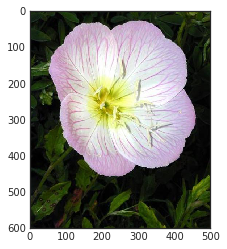

In [35]:
im = Image.open("flowers/test/1/image_06743.jpg", 'r')
np_image = np.asarray(im)
plt.imshow(np_image)

shape: (224, 224, 3)


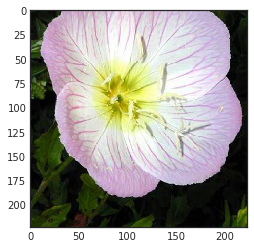

In [36]:
imshow(process_image(im))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [45]:
def softmax(x):
    '''used to squash probabilities during prediction'''
    return torch.exp(x) / torch.sum(torch.exp(x))

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.train(False)
    model.eval()
    np_image = process_image(image_path)
    # np_image = np_image.transpose((1, 2, 0))
    image = torch.from_numpy(np_image)
    image = image.type(torch.FloatTensor)
    image = image.unsqueeze(0)
    image = image.cuda()
    output = model(image)
    prob_output = softmax(output)
    probs, classes = prob_output.topk(topk)
    flower_names = []
    for flower_name_idx in classes[0]:
        flower_names.append(cat_to_name[str(int(flower_name_idx) + 1)])
    
    probs = probs.cpu().detach().numpy()[0]
    
    fig, ax = plt.subplots()
    ax.barh(np.arange(5), probs, align='center')
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(flower_names)
    ax.invert_yaxis()

    for i, prob in enumerate(probs):
        ax.text(prob + (np.max(probs) / 100), i+.1, 
                round(prob,3), color='black', fontweight='bold')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('SOFTMAX PROBABILITY')
    ax.set_title('PREDICTED PROBABILITIES')
    plt.show()

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

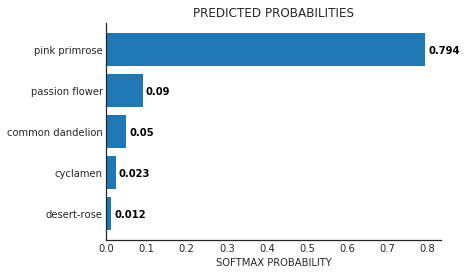

In [46]:
im = Image.open("flowers/test/1/image_06743.jpg", 'r')
predict(im, loaded_vgg16)

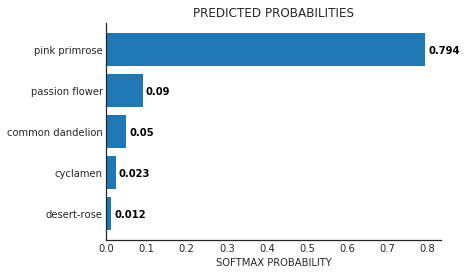

In [47]:
# make sure the loading function is loading the same vgg 
# should be the same as the output above
predict(im, vgg16)